# Visualizing TimeSeries Data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
meta_data = pd.read_csv('meta.csv')
train_data = pd.read_csv('consumption_train.csv')
test_data = pd.read_csv('cold_start_test.csv')
submission = pd.read_csv('submission_format.csv')

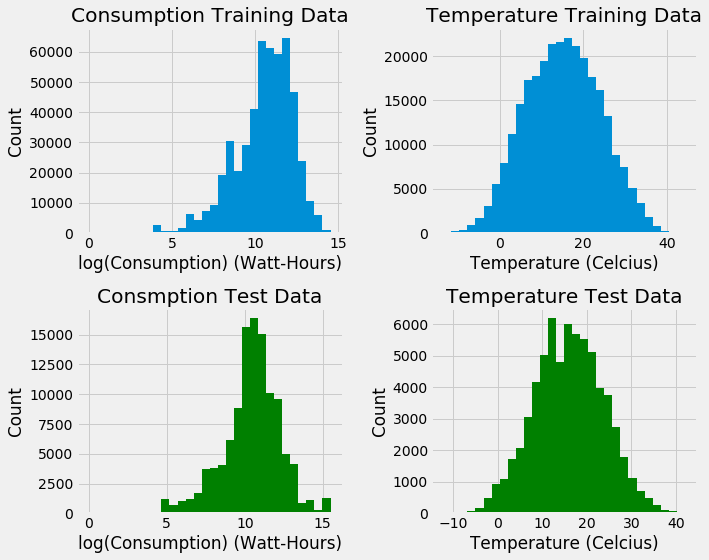

In [40]:
meta_data.nunique()

series_id               1383
surface                    7
base_temperature           2
monday_is_day_off          2
tuesday_is_day_off         2
wednesday_is_day_off       2
thursday_is_day_off        2
friday_is_day_off          2
saturday_is_day_off        2
sunday_is_day_off          2
dtype: int64

In [41]:
"""Change the types of timestamp columns and set the index"""

train_data.timestamp = pd.to_datetime(train_data.timestamp)
test_data.timestamp = pd.to_datetime(test_data.timestamp)

train_data.index = train_data.timestamp
test_data.index = test_data.timestamp

In [43]:
train_data.drop('timestamp', axis=1, inplace=True)
train_data.drop('Unnamed: 0', axis=1, inplace=True)

test_data.drop('timestamp', axis=1, inplace=True)
test_data.drop('Unnamed: 0', axis=1, inplace=True)

In [44]:
train_data.isnull().sum()/train_data.shape[0]

series_id      0.000000
consumption    0.000000
temperature    0.448959
dtype: float64

In [45]:
test_data.isnull().sum()/test_data.shape[0]

series_id      0.000000
consumption    0.000000
temperature    0.401093
dtype: float64

In [46]:
unik_series_id = train_data.series_id.unique()
value_counts_id = train_data.series_id.value_counts()
Missing = []
for id_ in unik_series_id :
    Missing.append(train_data[train_data.series_id==id_].isnull().sum()['temperature']/value_counts_id[id_])
    
df_id = pd.DataFrame({'Id':unik_series_id, '%missing' : Missing})

In [47]:
df_id = df_id.sort_values(by='%missing', ascending=False)
df_id.head(10)

,Id,%missing
379,101822,1.0
334,102530,1.0
343,102546,1.0
342,100517,1.0
341,100948,1.0
340,103397,1.0
339,102504,1.0
338,103179,1.0
337,101075,1.0
336,102514,1.0


In [48]:
train_data.nunique()

series_id         758
consumption    276923
temperature     16526
dtype: int64

In [49]:
train_data.shape

(509376, 3)

## LINE PLOT

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000233A77C1710>,
      dtype=object)

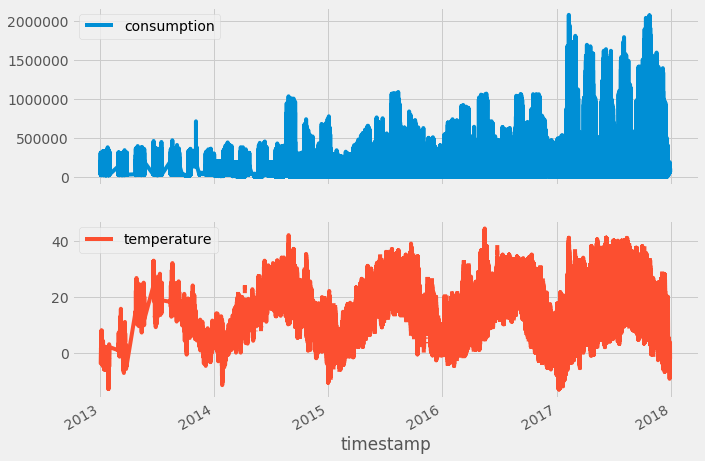

In [50]:
train_data[['consumption', 'temperature']].plot(subplots=True, figsize=(10, 8))

In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 509376 entries, 2014-12-24 00:00:00 to 2017-12-18 23:00:00
Data columns (total 3 columns):
series_id      509376 non-null int64
consumption    509376 non-null float64
temperature    280687 non-null float64
dtypes: float64(2), int64(1)
memory usage: 15.5 MB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000233B401B5F8>,
      dtype=object)

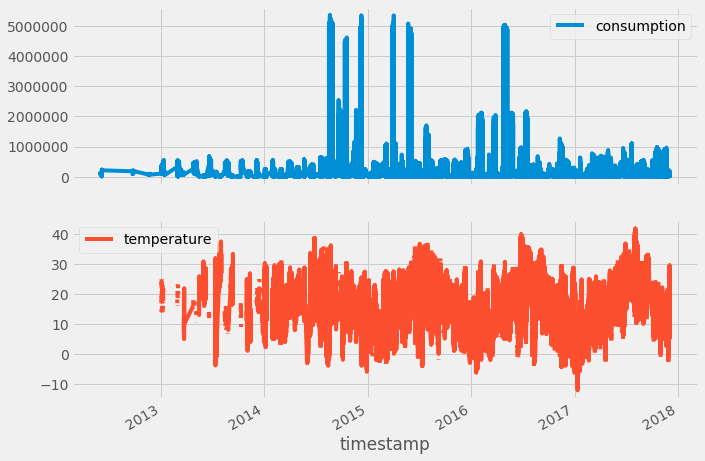

In [52]:
# How abouot Test Data

test_data[['consumption', 'temperature']].plot(subplots=True, figsize=(10, 8))

- Garis yang semakin tebal menunjukan bahwa temperature semakin beragam dan konsumsi listrik semakin banyak
- Terdapat perbedaan pola konsumsi pada data train dan data test soal jumlah konsumsi dan temperatur terhadap waktu. pada test data cenderung memiliki nilai yang lebih ditinggi di bandingkan dengan data training. baik itu pada nilai konsumsi mapun temperatur

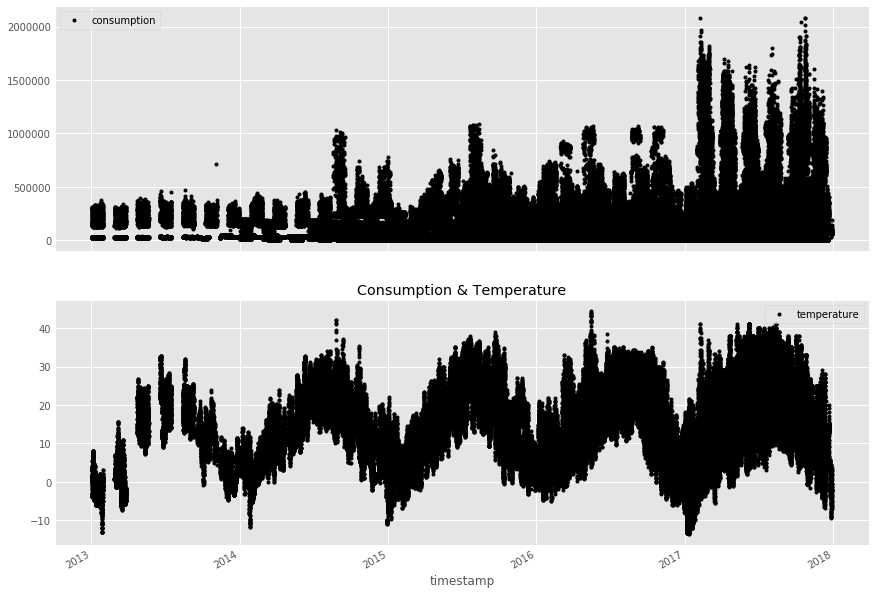

In [53]:
plt.style.use('ggplot')
train_data[['consumption', 'temperature']].plot(subplots=True, figsize=(13, 11), style='k.')
plt.title('Consumption & Temperature')
plt.show()

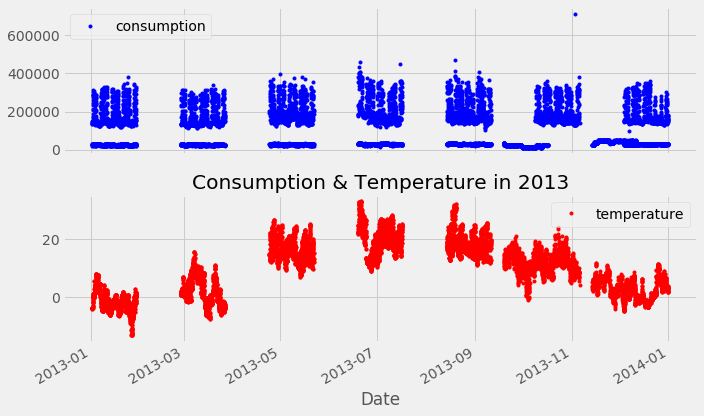

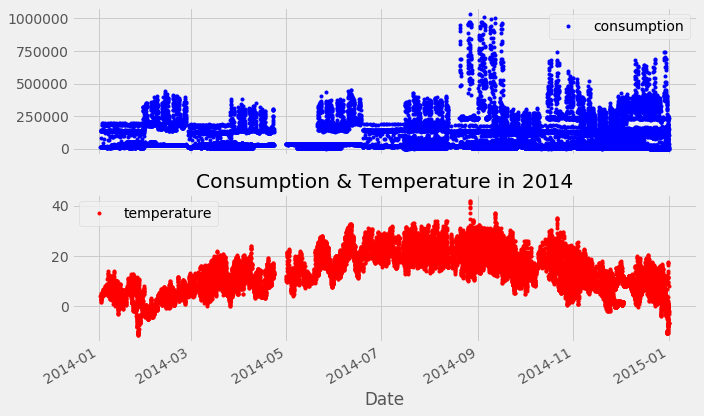

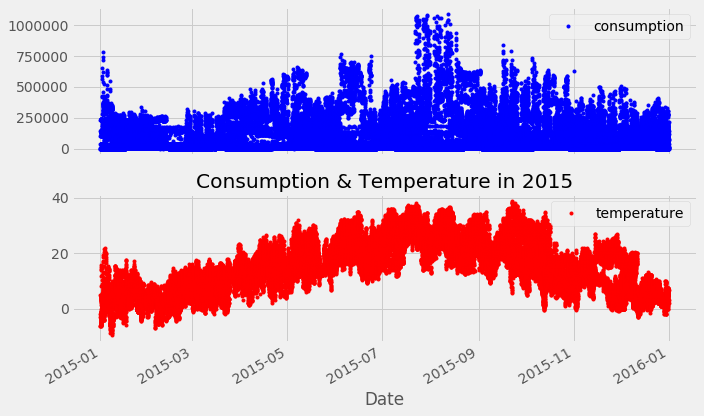

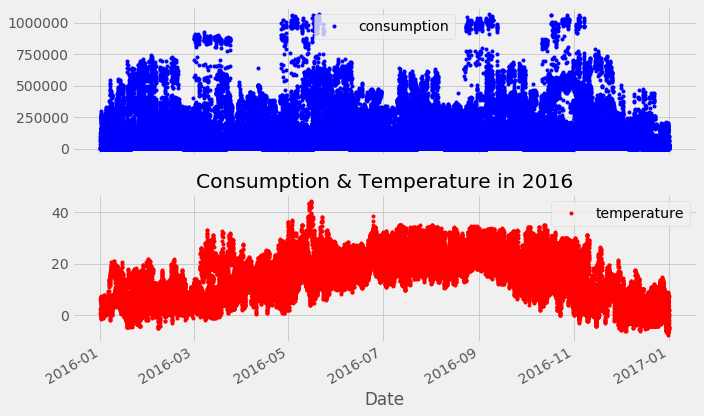

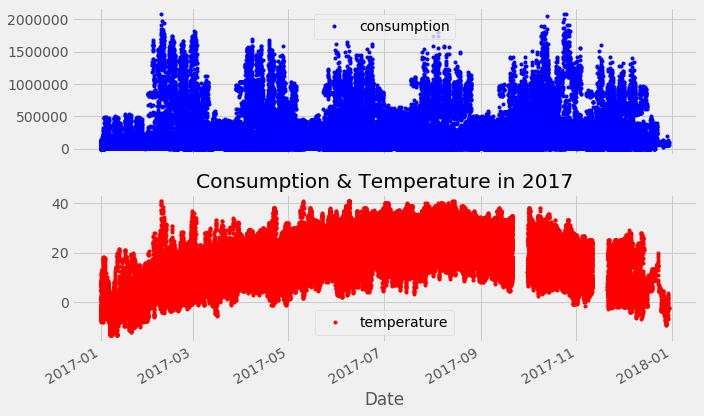

In [54]:
temperatures = train_data.temperature
consumptions = train_data.consumption

plt.style.use('fivethirtyeight')
years = np.arange(2013, 2018)
for year in years :
    train_data[['consumption', 'temperature']][str(year)].plot(subplots=True, figsize=(10, 6), style=['b.', 'r.'])
    plt.title('Consumption & Temperature in {}'.format(year))
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()
    print('='*127*2)

### Insight

- seen that consumption from year to year is increasing, so years will be a good feature to be the input in our model
- The month will also be a good feature. there is a seasonal pattern from month to month.
- There is some noise in data

Next we wil inspect the pattern in days

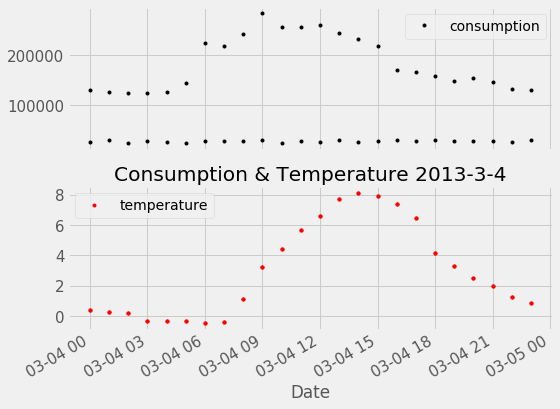

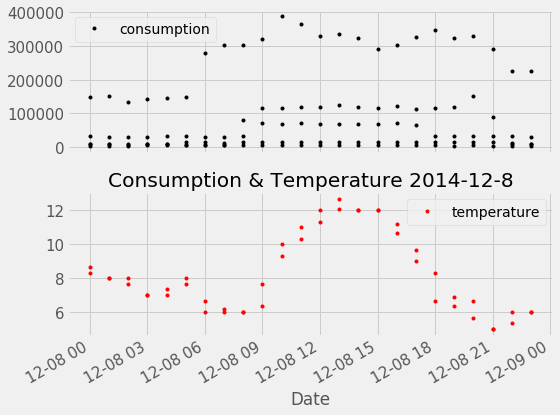

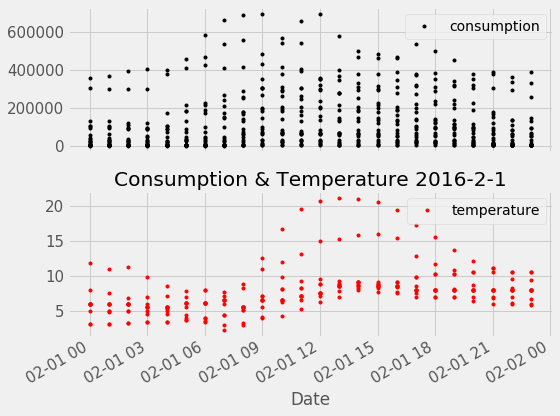

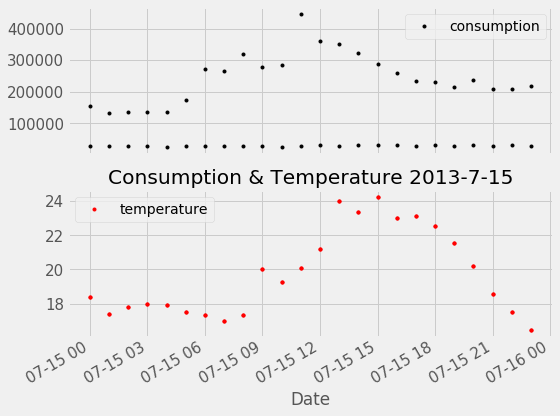

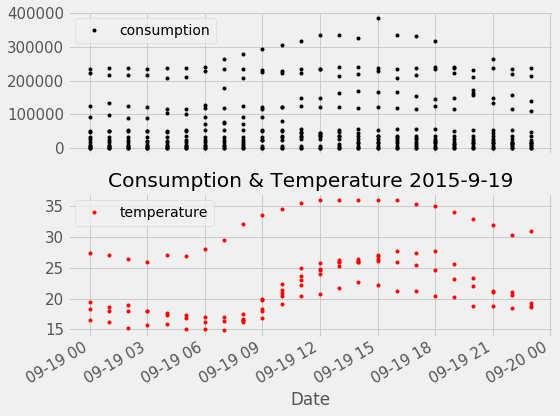

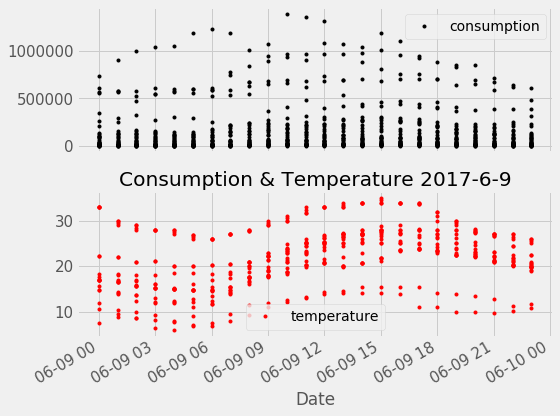

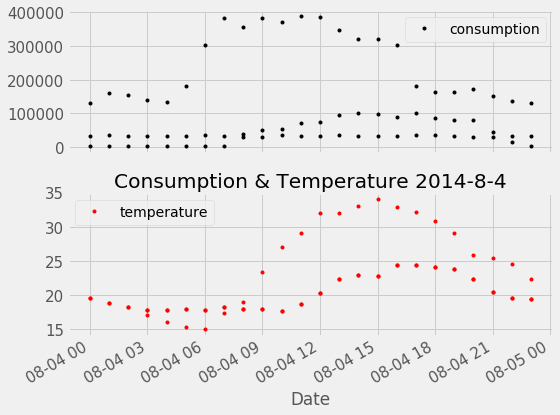

In [55]:
"""Randomly choice date"""

from numpy.random import choice

days = choice(np.arange(1, 29), size=7)
months = choice(np.arange(1, 13), size=7)
years = choice(np.arange(2013, 2018), size=7)

plt.style.use('seaborn-bright')
for year, month, day in zip(years, months, days) :
    date = str(year)+'-'+str(month)+'-'+str(day)
    if date in train_data.index :
        train_data[['consumption', 'temperature']][date].plot(subplots=True, figsize=(8, 6), style=['k.', 'r.'], grid=True, fontsize=15)
        plt.title('Consumption & Temperature {}'.format(date))
        plt.xlabel('Date')
        plt.tight_layout()
        plt.show()
        print('='*127*2)

- Consumption nearly uniform from hour to hour, but some date have pattern in consomption by hour to hour
- There is some correlation bettwen temperature/hour and consumption/hour

Now we will inspect about the behavioral of temperature in some buildings

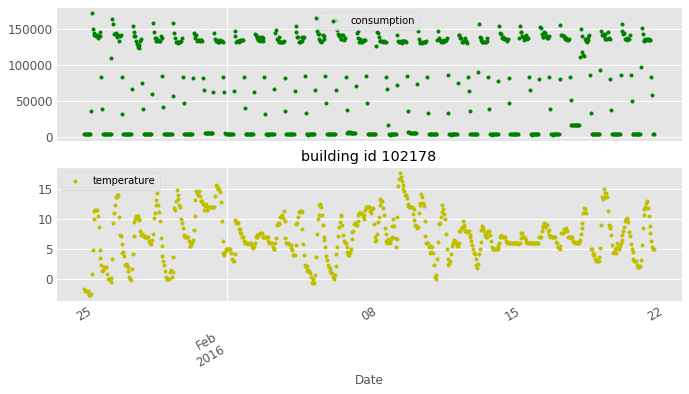

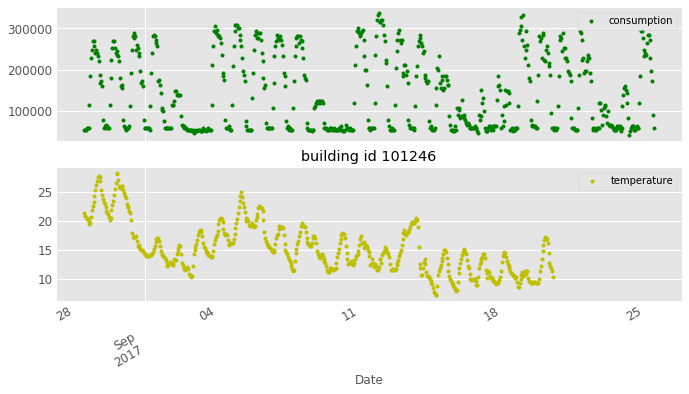

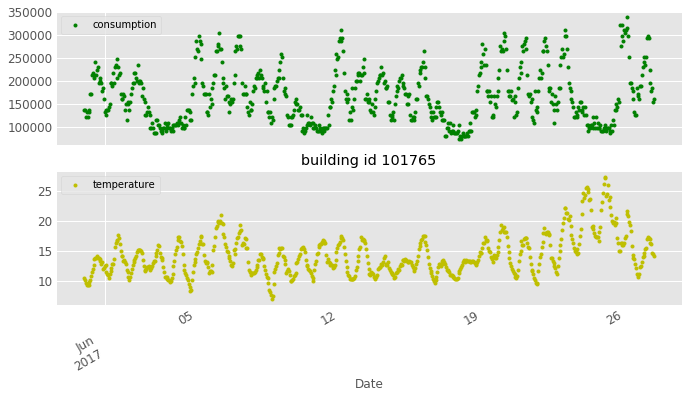

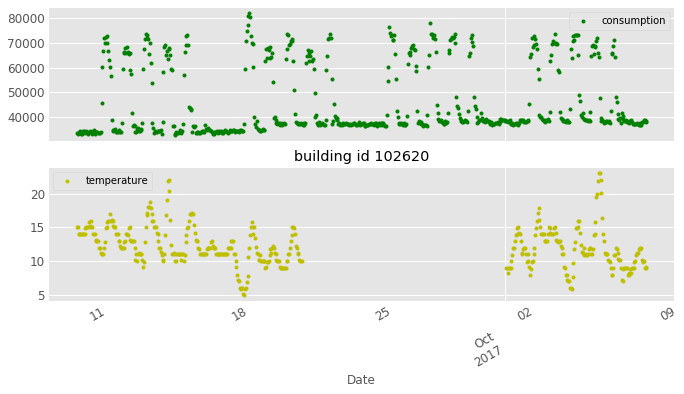

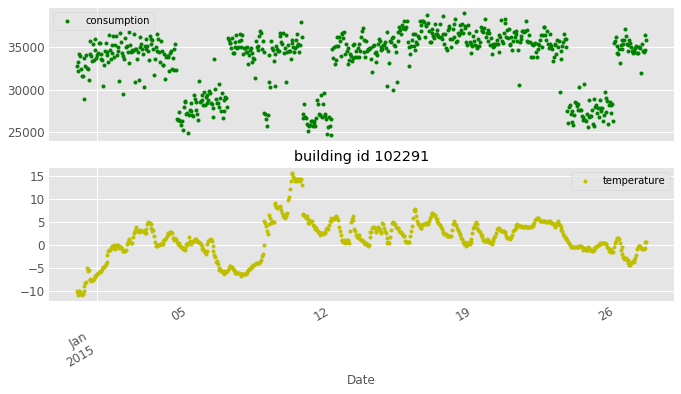

In [56]:
random_building = choice(train_data.series_id.unique(), size=7)

plt.style.use('ggplot')
for building in random_building :
    if df_id[df_id.Id==building]['%missing'].values < 0.7 :
        train_data[['consumption', 'temperature']][train_data.series_id==building].plot(subplots=True,grid=True, 
                                                                                        style=['g.', 'y.'], 
                                                                                        figsize=(10,6), 
                                                                                        fontsize=12)
        plt.title('building id {}'.format(building))
        plt.xlabel('Date')
        plt.show()

"""One of the challenges is in the way we fill in the missing values. because many buildings have a temperature value that is lost up to 100%. meaning that for one year the temperature inside the building is unknown!!.

we cannot fill this missing value with linear interpolation, even if it has to be non-linear we will have difficulty determining the degree of non-linearity.

Because all series IDs have the same pattern regarding the temperature value. then it's have to be good if we try to build a model that will predict the temperature value. this is a gonna be like other project though, but it's worth it since we have missinig value almost 50%""""

=======================================

"""For electricity consumption in each building, it seems that each building has a different consumption pattern. may depend on the type of building. there are buildings that always need electricity every time. there are also buildings that only require electricity when at certain times such as working hours and then a little consumption at night."""

In [57]:
train_data['year'] = train_data.index.year
train_data['month'] = train_data.index.month_name()

test_data['year'] = test_data.index.year
test_data['month'] = test_data.index.month

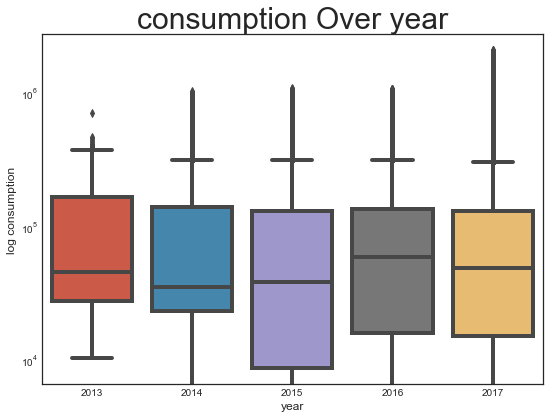

In [58]:
def plot_boxplot(feature_x, feature_y, data_, log = False) :
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-white')
    sns.boxplot(x=feature_x, y=feature_y, data=data_)
    if log == True :
        plt.yscale('log')
        plt.ylabel('log {}'.format(feature_y))
    else :
        plt.ylabel(feature_y)
    plt.title('{} Over {}'.format(feature_y, feature_x), fontsize=30)
    plt.show()

plot_boxplot('year', 'consumption', data_=train_data, log=True)

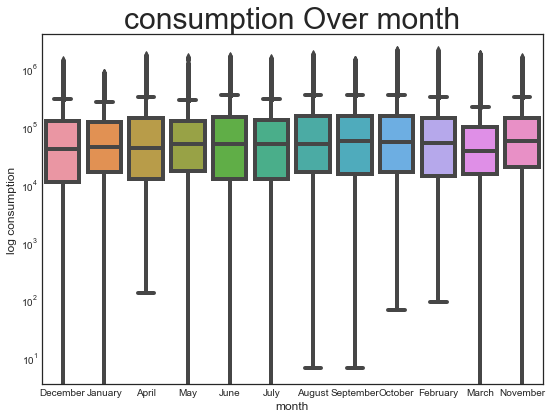

In [59]:
plot_boxplot('month', 'consumption', train_data, True)

In [60]:
train_data['Tanggal'] = train_data.index.day
train_data['Name_of_Day'] = train_data.index.day_name()
train_data['Hours'] = train_data.index.hour

test_data['Tanggal'] = test_data.index.day
test_data['Name_of_Day'] = test_data.index.day_name()
test_data['Hours'] = test_data.index.hour

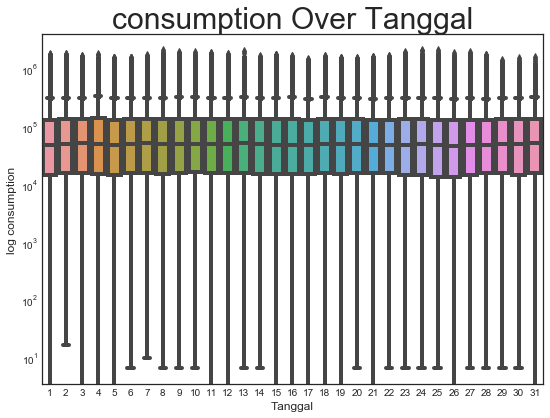

In [61]:
plot_boxplot('Tanggal', 'consumption', train_data, True)

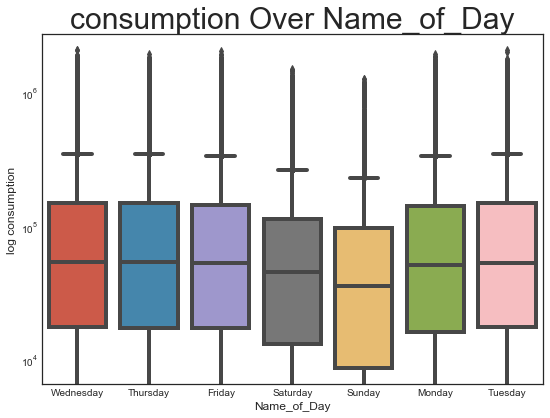

In [62]:
plot_boxplot('Name_of_Day', 'consumption', train_data, True)

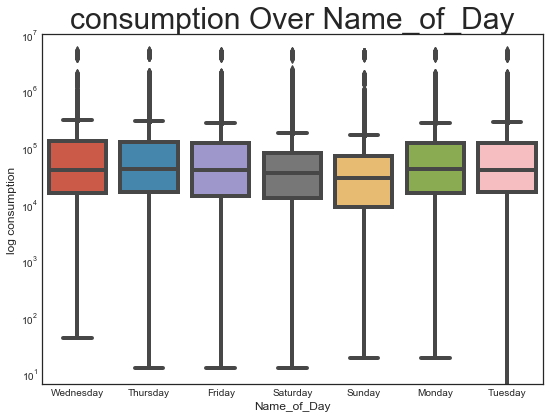

In [63]:
plot_boxplot('Name_of_Day', 'consumption', test_data, True)

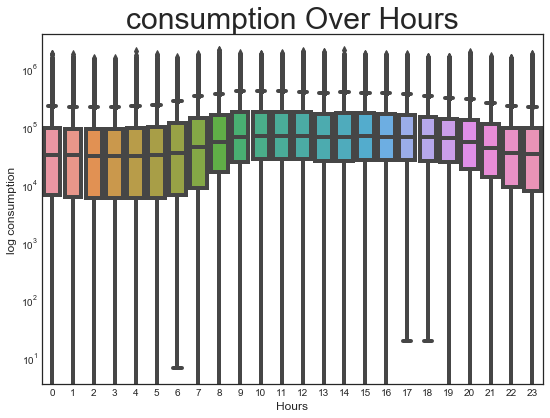

In [64]:
plot_boxplot('Hours', 'consumption', train_data, True)

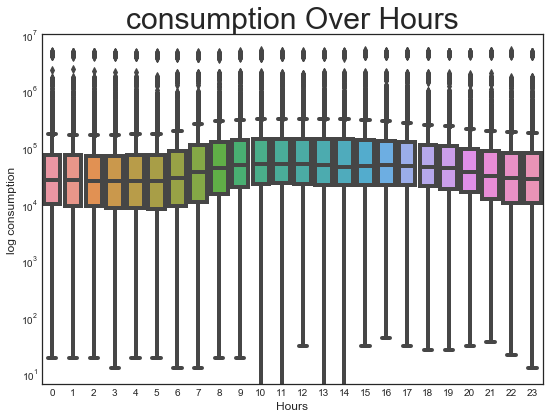

In [65]:
plot_boxplot('Hours', 'consumption', test_data, True)

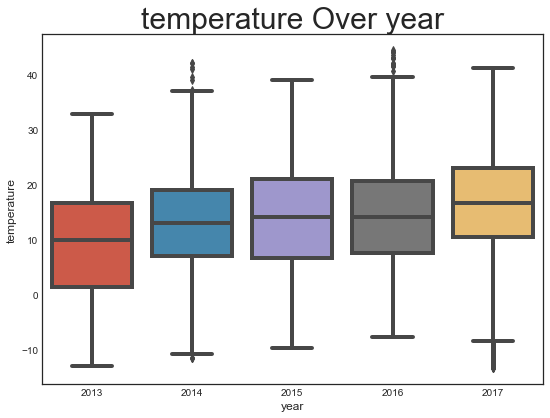

In [66]:
plot_boxplot('year', 'temperature', train_data)

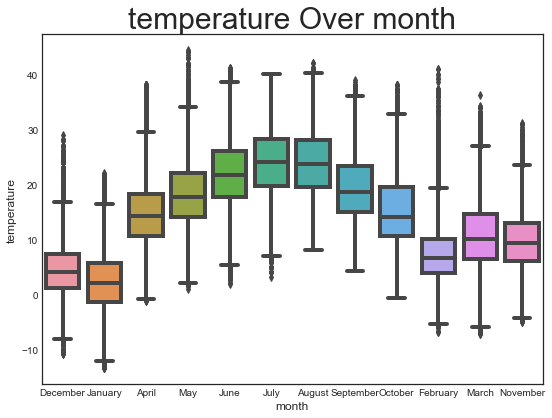

In [67]:
plot_boxplot('month', 'temperature', train_data)

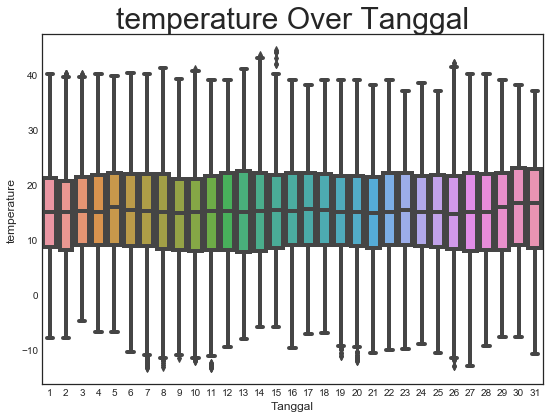

In [68]:
plot_boxplot('Tanggal', 'temperature', train_data)

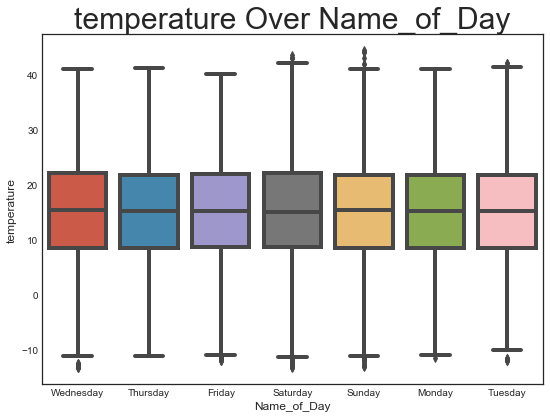

In [69]:
plot_boxplot('Name_of_Day', 'temperature', train_data)

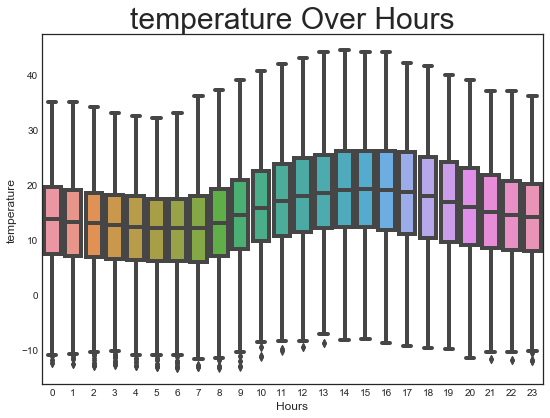

In [70]:
plot_boxplot('Hours', 'temperature', train_data)

Okay, so many visualization on box plot we made here. what we got? This is what I got

Talk about electricity consumption : 
- There is a changes in consumption pattern over year. but it's not abvious the rule of pattern. and I dont know is it significant or not. but it's my hipotesis.
- There is no really abvious pattern of electricity consumption over month and day of month.
- There is a pattern in the name of day, the consumpton is low in holiday (saturday and sunday) than in work days.
- There is a pattern in series of hours, which is the high consumption at work time.

We need to talk about Temperature due to we wanna build predictive model for temperature because of the need of fill in the missing value :
- The temperature seem to be increase over year.
- The temperature seem to be have seasonal pattern in series of month.
- The temperature seem to be constant in the day of month and in the day of week.
- Of course, the temperature is higher in the daytime hours

What about you? do you got anything else beside above

# Time Series Scatter Plot

### Lag Plot

C:\Users\Data Scientist\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  after removing the cwd from sys.path.


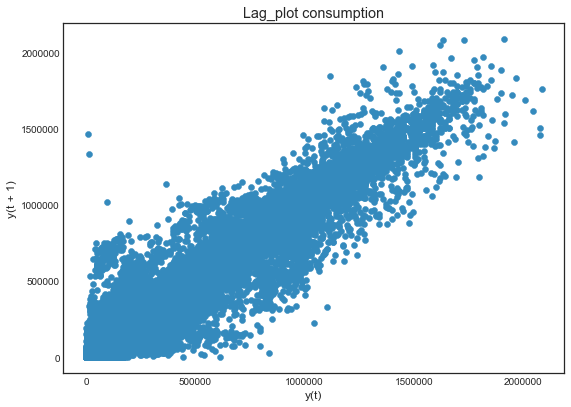

In [71]:
from pandas.tools.plotting import lag_plot

plt.figure(figsize=(8,6))
lag_plot(train_data.consumption)
plt.title('Lag_plot consumption')
plt.show()

In [81]:
shifts = np.arange(1, 12)

consumption_shift = {"consumption_lag_{}_hours".format(day_shift): train_data.consumption.shift(day_shift) for day_shift in shifts}

df_consumption_shift = pd.DataFrame(consumption_shift)

df_consumption_shift = pd.concat([train_data.consumption, df_consumption_shift], axis=1)

In [82]:
df_consumption_shift.head()

,consumption,consumption_lag_1_hours,consumption_lag_2_hours,consumption_lag_3_hours,consumption_lag_4_hours,consumption_lag_5_hours,consumption_lag_6_hours,consumption_lag_7_hours,consumption_lag_8_hours,consumption_lag_9_hours,consumption_lag_10_hours,consumption_lag_11_hours
timestamp,,,,,,,,,,,,
2014-12-24 00:00:00,101842.233424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-24 01:00:00,105878.048906,101842.233424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-24 02:00:00,91619.105008,105878.048906,101842.233424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-24 03:00:00,94473.706203,91619.105008,105878.048906,101842.233424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-24 04:00:00,96976.755526,94473.706203,91619.105008,105878.048906,101842.233424,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
def plot_scatter(x, y, data) :
    plt.figure(figsize=(8, 6))
    plt.scatter(x=data[x], y=data[y])
    plt.title("{} vs {}".format(x, y))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

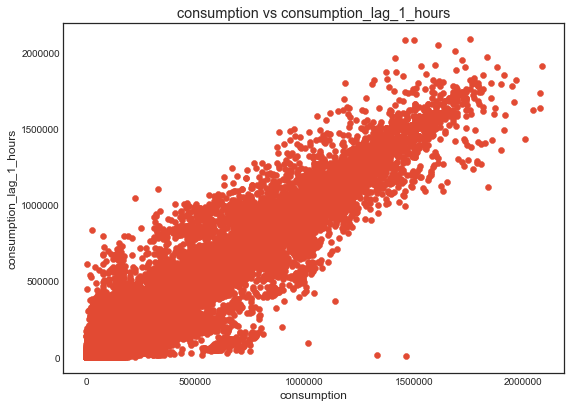

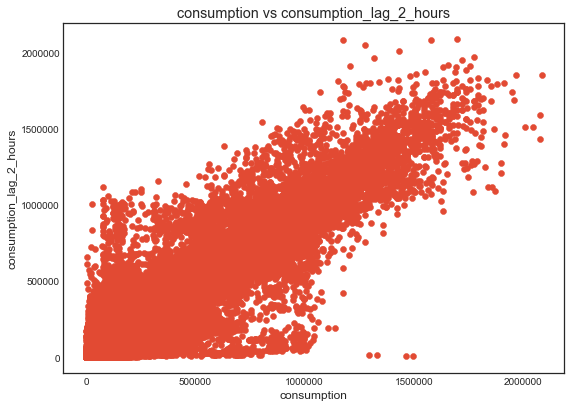

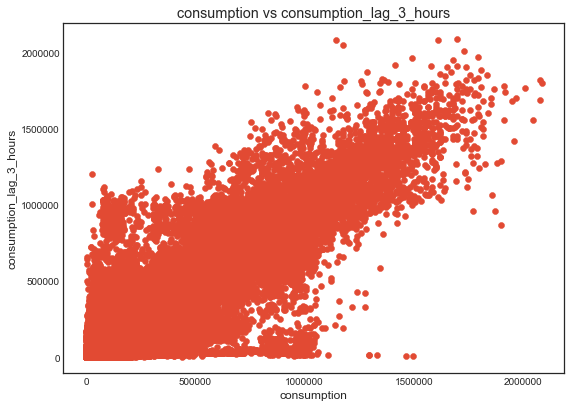

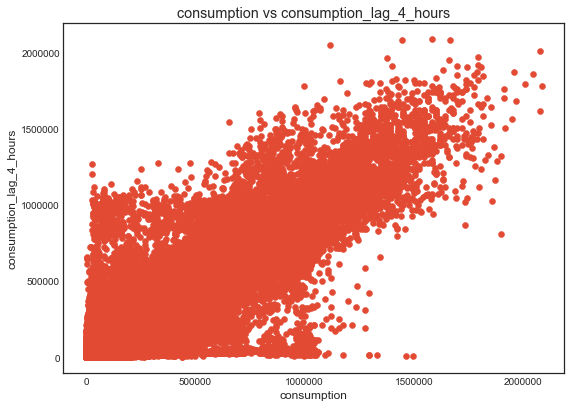

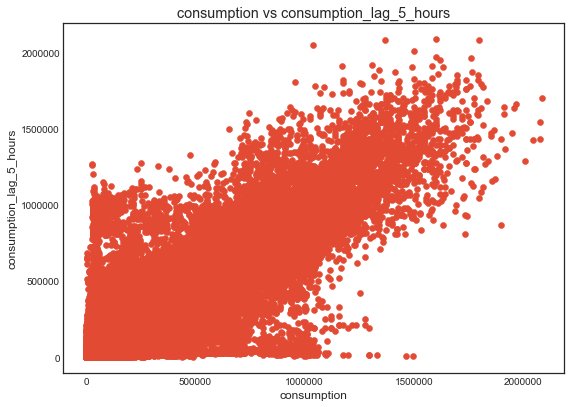

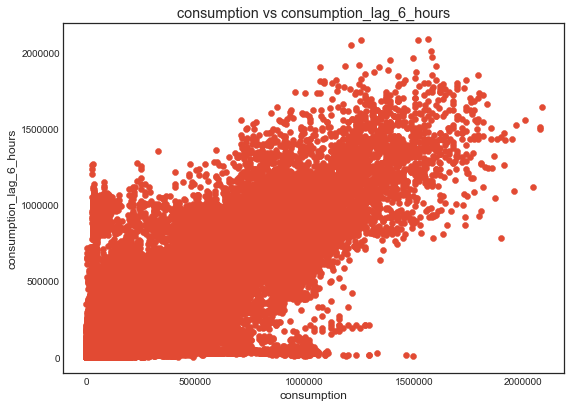

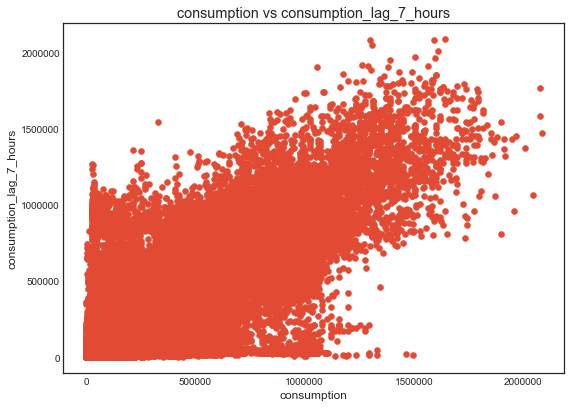

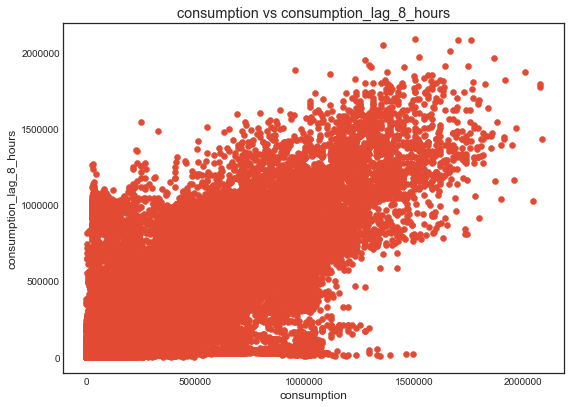

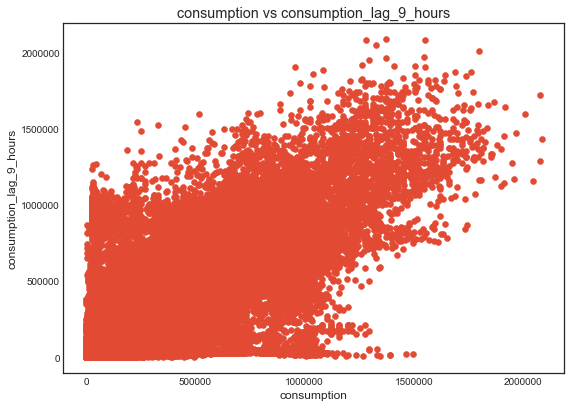

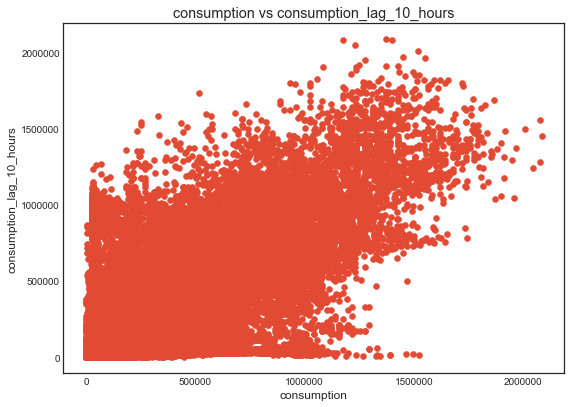

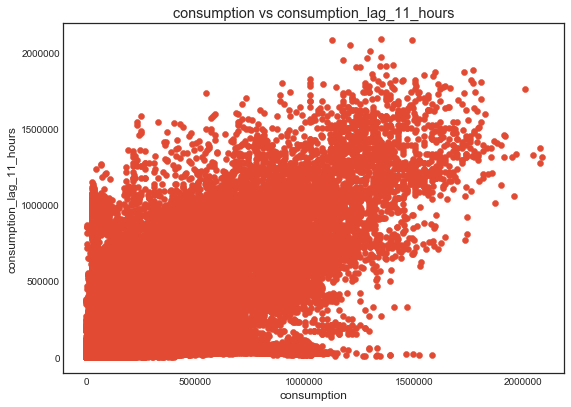

In [90]:
for col in df_consumption_shift.columns[1:] :
    plot_scatter('consumption', col, df_consumption_shift)

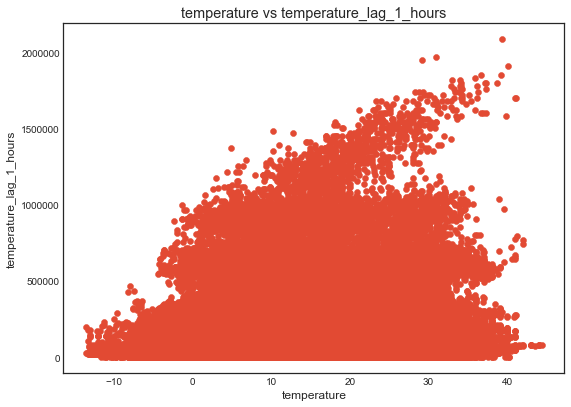

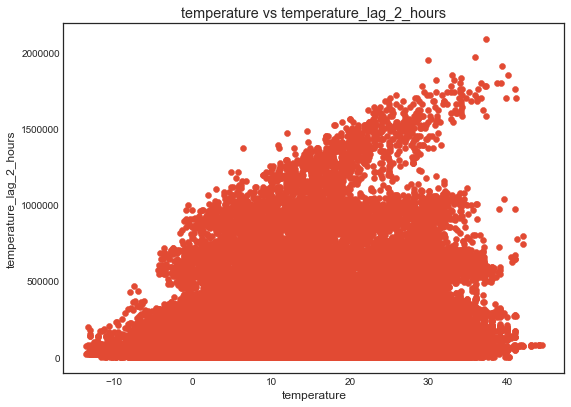

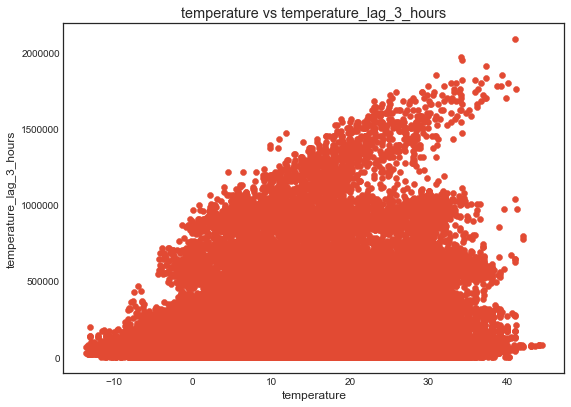

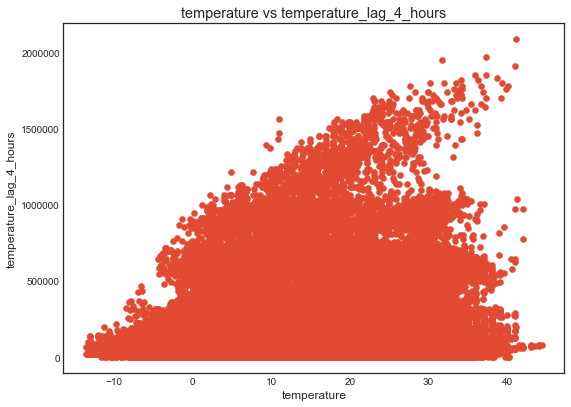

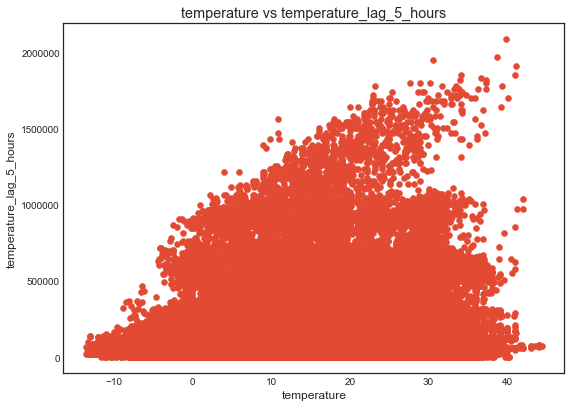

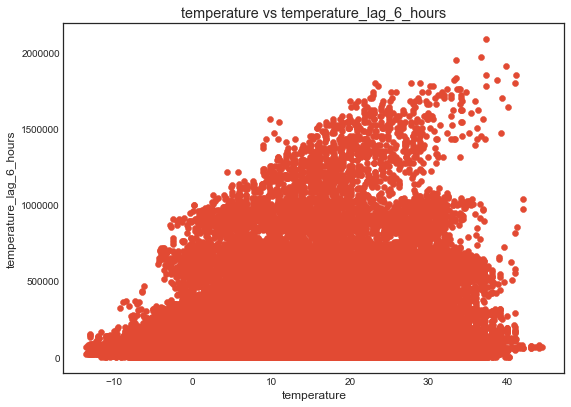

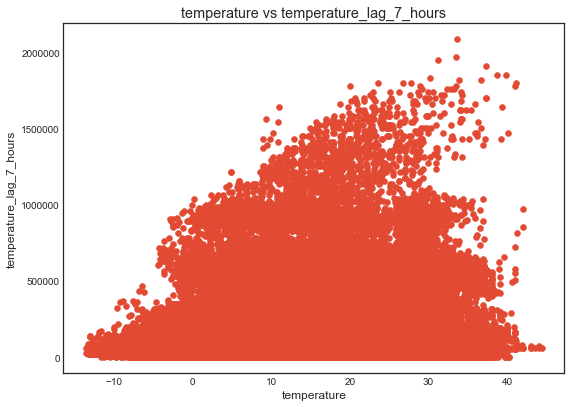

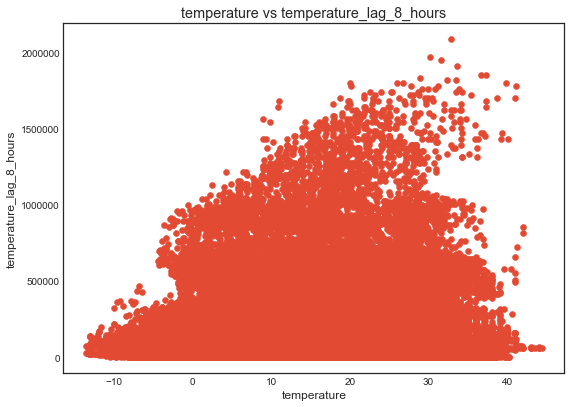

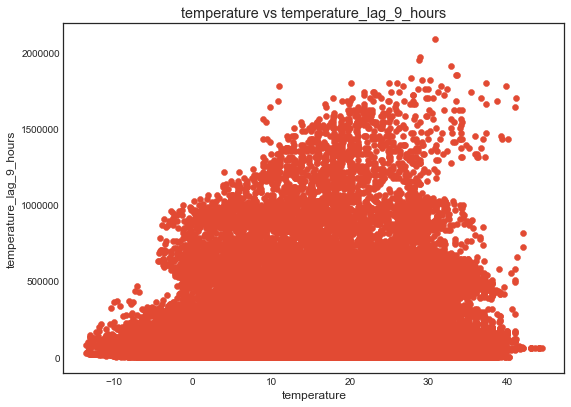

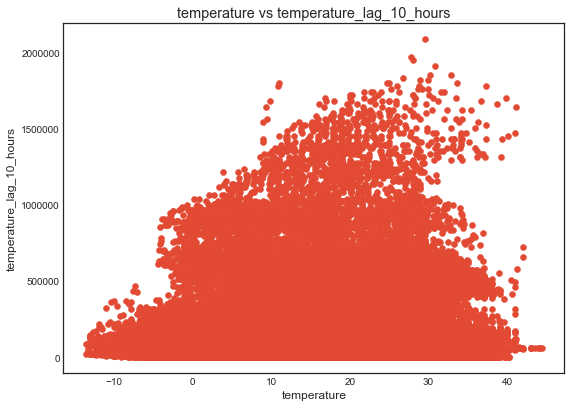

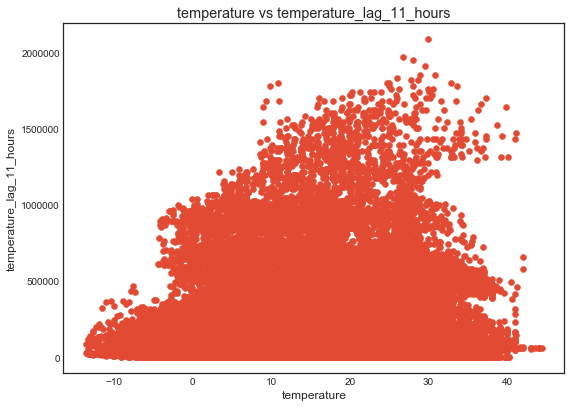

In [91]:
temperature_shift = {"temperature_lag_{}_hours".format(day_shift): train_data.consumption.shift(day_shift) for day_shift in shifts}

df_temperature_shift = pd.DataFrame(temperature_shift)

df_temperature_shift = pd.concat([train_data.temperature, df_temperature_shift], axis=1)


for col in df_temperature_shift.columns[1:] :
    plot_scatter('temperature', col, df_temperature_shift)

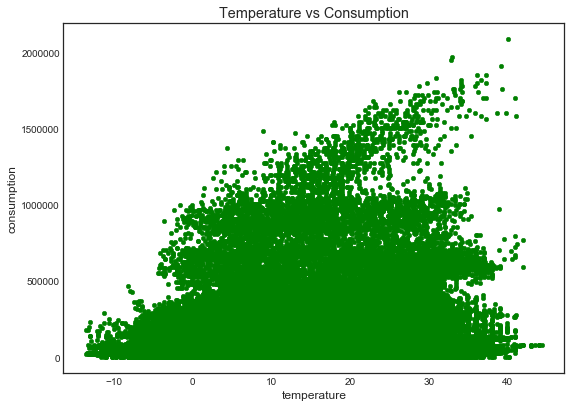

In [96]:
train_data.plot.scatter(x='temperature', y='consumption', c='green', figsize=(8, 6))
plt.title('Temperature vs Consumption')
plt.show()

- the variance in consumption vs. lag increases with further lag
- temperature vs temperature lag-k seem have to be same 

# Time Series AutoCorrelation Plot

C:\Users\Data Scientist\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


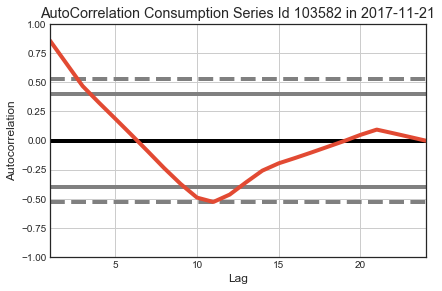

In [114]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(train_data[train_data.series_id==103582].consumption['2017-11-21'])
plt.title('AutoCorrelation Consumption Series Id 103582 in 2017-11-21')
plt.show()

C:\Users\Data Scientist\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


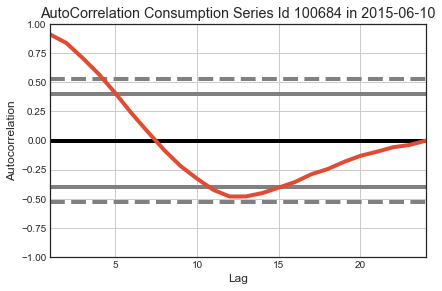

In [115]:
autocorrelation_plot(train_data[train_data.series_id==100684].consumption['2015-06-10'])
plt.title('AutoCorrelation Consumption Series Id 100684 in 2015-06-10')
plt.show()

C:\Users\Data Scientist\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


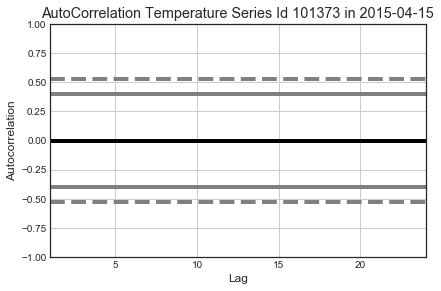

In [126]:
autocorrelation_plot(train_data[train_data.series_id==101373].temperature['2015-04-15'])
plt.title('AutoCorrelation Temperature Series Id 101373 in 2015-04-15')
plt.show()

C:\Users\Data Scientist\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


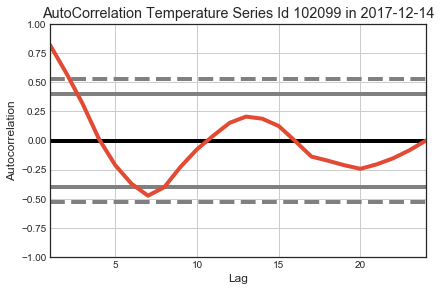

In [125]:
autocorrelation_plot(train_data[train_data.series_id==102099].temperature['2017-12-14'])
plt.title('AutoCorrelation Temperature Series Id 102099 in 2017-12-14')
plt.show()